---

<div align='center'>
<font size="+2">

TM&NLP - Project

<b>Classification Between Multiple Choices </b>

Ghiotto Alessandro 513944

</font>
</div>

---

# Notebook 3 - Contextualized Embeddings:

# **TO BE UPDATED**

1. Representation by means of static word embeddings:
    - Word2Vec
    - GloVE
    - FastText
    - Doc2Vec
2. Other ways of combining word embeddings:
    - Remove duplicated words
    - Word embeddings weighted by their idf score
3. Other ways of choosing the answer:
    - Siamese Neural Network
    - Feed Forward Neural Network


---

Load Data

In [13]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
sns.set_theme(style="darkgrid")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# set the seed
seed = 8
set_seed(seed)

# set gpu as default device and float32 as default dtype
mydevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(mydevice) # default tensor device
torch.set_default_dtype(torch.float32) # default tensor dtype

dataset = load_dataset("allenai/qasc")

n_train_sample = 7323
dataset_train = dataset['train'].select(range(n_train_sample))
dataset_val = dataset['train'].select(range(n_train_sample, len(dataset['train'])))
dataset_test = dataset['validation']

def format_choices(example):
    # transform the choices from a dictionary to a list of strings
    # I will eliminate the labels, if we know that the order is always the same
    # Does all the samples have the same order of choices?
    if example['choices']['label'] == ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        # get the text of the choices
        example['choices'] = example['choices']['text']
    else:
        print("The order of the choices is not the same for all the examples")
    return example

dataset_train = dataset_train.map(format_choices)
dataset_val = dataset_val.map(format_choices)
dataset_test = dataset_test.map(format_choices)

# Display the dataset
dataset_train[0]

Map:   0%|          | 0/7323 [00:00<?, ? examples/s]

Map:   0%|          | 0/811 [00:00<?, ? examples/s]

{'id': '3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K',
 'question': 'What type of water formation is formed by clouds?',
 'choices': ['pearls',
  'streams',
  'shells',
  'diamonds',
  'rain',
  'beads',
  'cooled',
  'liquid'],
 'answerKey': 'F',
 'fact1': 'beads of water are formed by water vapor condensing',
 'fact2': 'Clouds are made of water vapor.',
 'combinedfact': 'Beads of water can be formed by clouds.',
 'formatted_question': 'What type of water formation is formed by clouds? (A) pearls (B) streams (C) shells (D) diamonds (E) rain (F) beads (G) cooled (H) liquid'}

---

# **BidirectionalLSTM**

As contextualized word embeddings I will take the output of the BidirectionalLSTM Neural Network. Then I will feed it to a classification head (MLP). The task is Binary classification (1 for the correct choice, 0 otherwise), `loss = 'binary_cross_entropy'`

First we need to build the tokenizer, I will use **WordPiece** tokenizer

**First we build the tokenizer**

In [14]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders

vocab_size = 15000
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

# decoding technique: how to put back together our subwords
tokenizer.decoder = decoders.WordPiece()

# we can set various special tokens (extra) useful for handling specific cases if needed.
trainer = WordPieceTrainer(vocab_size=vocab_size,
                     special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase

# PREPROCESSING STEPS
# before tokenization we lowercase all words
tokenizer.normalizer = Lowercase()
# This pre-tokenizer simply splits using the following regex: \w+|[^\w\s]+ (spaces and punctuations)
tokenizer.pre_tokenizer = Whitespace()

# TRAIN
# generate a text file containing all the texts
with open("tokenizers/qasc_textForTokenizer.txt", "w", encoding="utf-8") as f:
    # remove duplicates (a lot of facts are repeated)
    train_texts = list(set(dataset_train["question"] + dataset_train["fact1"] + dataset_train["fact2"]))
    for i in range(len(train_texts)):
        f.write(train_texts[i] + "\n")

train_file = "tokenizers/qasc_textForTokenizer.txt"
files = [train_file]
tokenizer.train(files, trainer)

# save as a json file (so we can use it for later for example)
saved_tokenizer = "tokenizers/WordPiece_tokenizer.json"
tokenizer.save(saved_tokenizer)

### EXAMPLE
# load the tokenizer
tokenizer = Tokenizer.from_file(saved_tokenizer)
# decoding technique: how to put back together our subwords
tokenizer.decoder = decoders.WordPiece()
# encode a sentence
sentence = "What is the capital of France?"
encoded = tokenizer.encode(sentence)
print(sentence)
print(encoded)
print(encoded.ids)
print(encoded.tokens)




What is the capital of France?
Encoding(num_tokens=10, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
[104, 118, 106, 1804, 124, 108, 114, 4528, 159, 25]
['what', 'is', 'the', 'cap', '##it', '##al', 'of', 'fran', '##ce', '?']


In [15]:
MAX_LENGTH = 300

# MAKE IT FAST + PADDING + TRUNCATION

# load the tokenizer
tokenizer = Tokenizer.from_file(saved_tokenizer)

# Enabling padding with the right chosen index
pad_id = tokenizer.token_to_id("[PAD]")
print("PAD ID: "+str(pad_id))
tokenizer.enable_padding(pad_id=pad_id, pad_token="[PAD]")

from transformers import PreTrainedTokenizerFast
# we can use a fast version of our tokenizer
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)
# we can set the cut-off threshold for how long (i.e. how many words in a sentence) we want to handle our sentences
# all the words after MAX_LEGTH are just remove (truncate excessive contexts) (also for memory reasons)
fast_tokenizer.model_max_length = MAX_LENGTH
# truncate on the left, so I keep the choice which is at the end
fast_tokenizer.truncation_side = 'left'

vocab_size = len(fast_tokenizer)
print("VOCABULARY SIZE: "+str(vocab_size))
padding_idx = fast_tokenizer.pad_token_id
print("CHECK PADDING IDX: "+str(padding_idx))

PAD ID: 0
VOCABULARY SIZE: 11829
CHECK PADDING IDX: 0


Since this sentences of the dataset are quite specific, we have reached a vocabulary size equal to the number of unique words in the data.

In [16]:
# TOKENIZE THE FULL TRAINING DATA
def preprocess_function(examples):
    # question + fact1 + fact2 + choice
    # we do it for all choices (for each example)
    sentences = [
        f"{examples['question']} {examples['fact1']} {examples['fact2']} {examples['choices'][choice_idx]}" 
        for choice_idx in range(8)
    ]
    
    # Tokenize
    tokenized_examples = fast_tokenizer(sentences, truncation=True)
    # I know that for each sample I have 8 choices
    # 0->A, 1->B, 2->C, 3->D, 4->E, 5->F, 6->G, 7->H
    # 8->A, ...
    return tokenized_examples

dataset_train_inputids = dataset_train.map(preprocess_function).with_format('torch')['input_ids']
dataset_train_inputids = [inputid for row in dataset_train_inputids for inputid in row]
print('number of samples: ', len(dataset_train_inputids))
example = dataset_train_inputids[0]
print('number of tokens in the first sample: ', len(example))
print('first sample: ', example)
print('decoded: ', fast_tokenizer.decode(example))

Map:   0%|          | 0/7323 [00:00<?, ? examples/s]

number of samples:  58584
number of tokens in the first sample:  28
first sample:  tensor([ 104,  530,  114,  183, 2361,  118,  408,  160, 1324,   25, 3601,  114,
         183,  121,  408,  160,  183,  733, 1924, 1324,  121,  504,  114,  183,
         733,   11,  513, 8689], device='cuda:0')
decoded:  what type of water formation is formed by clouds? beads of water are formed by water vapor condensing clouds are made of water vapor. pearls


In [17]:
# CREATE THE LABELS
# for each answerKey I create 8 labels (one for each choice)
# 0->A, 1->B, 2->C, 3->D, 4->E, 5->F, 6->G, 7->H
# 1 if the choice is correct, 0 otherwise
def create_labels(example):
    labels = []
    for i in range(8):
        if example['answerKey'] == chr(65+i):
            labels.append(1)
        else:
            labels.append(0)
    example['label'] = labels
    return example

# apply the function to the dataset and then flatten the list
# so that we have a list of length 8*len(dataset)
# I didn't used batches for semplicity (don't have many samples, and it's a simple operation)
labels = dataset_train.map(create_labels, remove_columns=dataset_train.column_names)
labels = [label for row in labels["label"] for label in row]
print('original train_set len:', len(labels))
print(labels[:8], 'corresponding to the first example', dataset_train['answerKey'][0])
print(labels[8:16], 'corresponding to the second example', dataset_train['answerKey'][1])

# CREATE THE DATASET
# I create a dictionary with the input_ids and the labels
# I will use this dictionary to create the Dataset object
data = {'input_ids': dataset_train_inputids, 'labels': labels}
data_train = Dataset.from_dict(data).with_format('torch')

# take a portion of the data for validation
data_val = data_train.train_test_split(test_size=0.1, seed=seed, shuffle=True)
data_train = data_val['train']
data_val = data_val['test']

print(data_train)

Map:   0%|          | 0/7323 [00:00<?, ? examples/s]

original train_set len: 58584
[0, 0, 0, 0, 0, 1, 0, 0] corresponding to the first example F
[0, 0, 0, 0, 1, 0, 0, 0] corresponding to the second example E
Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 52725
})


Now that we have tokenized the dataset and created the labels we can build the model, contituted by 2 BiLSTM layers + a classification head

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM_Classifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx, out_features=128, lstm_layers=1):
        # num_embeddings : size of the dictionary of embeddings
		# embedding_dim  : the size of each embedding vector
		# padding_idx : If specified, the entries at padding_idx do not contribute to the gradient
		# out_features : size of the output features
		# lstm_layers : number of recurrent layers
		
		# the embedding vector at padding_idx is not updated during training, it remains as a fixed “pad”
        super(BiLSTM_Classifier, self).__init__()
        self.lstm_layers = lstm_layers
        self.embedding_dim = embedding_dim

        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, num_layers=lstm_layers,
                            bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=embedding_dim * 2, out_features=out_features)
        self.fc2 = nn.Linear(out_features, 1)

    def forward(self, x):
        # Initialize the hidden state and the cell state
        # batch_size = x.size(0)
        # h = torch.zeros((self.lstm_layers * 2, batch_size, self.embedding_dim)).to(x.device)
        # c = torch.zeros((self.lstm_layers * 2, batch_size, self.embedding_dim)).to(x.device)
        # torch.nn.init.xavier_normal_(h)
		# torch.nn.init.xavier_normal_(c)

        embs = self.embedding_layer(x)
        out_lstm, (h_n, c_n) = self.lstm(embs)#, (h, c))

        # out_lstm : [batch_size, seq_len, 2*hidden_size]
		# the last element of out_lstm contains the final forward hidden state and the initial reverse hidden state
        # Get the last hidden state
        out = out_lstm[:, -1, :]
        out = self.dropout(out)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))

        return out

In [19]:
# HYPERPARAMETERS

embedding_dim = 256
out_features = 128
n_lstm_layers = 2
learning_rate = 5*1e-5
batch_size = 128
nb_epoch = 6

# ---------------------

from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from torchinfo import summary

# DataCollatorWithPadding will add the Padding automatically (saved in our tokenizer)
datacollator = DataCollatorWithPadding(tokenizer=fast_tokenizer)

# DataLoader : take care of loading batch of data from our training data
generator = torch.Generator(device=mydevice)
dataloader_train = DataLoader(data_train, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=datacollator, generator=generator)
dataloader_val = DataLoader(data_val, batch_size=batch_size, drop_last=False, shuffle=False, collate_fn=datacollator, generator=generator)

# instantiate the model
# vocab_size and padding_idx are taken from the tokenizer (saved before)
BiLSTM_model = BiLSTM_Classifier(vocab_size, embedding_dim, padding_idx, out_features=out_features, lstm_layers=n_lstm_layers)
BiLSTM_model.to(mydevice)
# PRINT THE MODEL ARCHITECTURE
print(summary(BiLSTM_model))

# Optimizer and Loss
optimizer = torch.optim.Adam(BiLSTM_model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

BiLSTM_model.train()

counter = []
loss_history_train = [] 
loss_history_val = []
i = 0
for epoch in range(nb_epoch):
    print("EPOCH "+str(epoch))
    for item in dataloader_train:#, disable=True):
        optimizer.zero_grad()
        item = item.to(mydevice) # for GPU
        # target = just the input, but start from the second word
        inp_ids, labels = item['input_ids'], item['labels']

        # output of the sigmoid is the probability of the correct class
        output = BiLSTM_model(inp_ids)

        # loss
        loss = loss_fn(output, labels.float().unsqueeze(1))

        # backpropagation
        loss.backward()

        # update the weights
        optimizer.step()
        
        i += 1
        # Every 100 batches print out the loss + save the loss
        if i % 100 == 0 :
            # compute the loss on the validation set
            BiLSTM_model.eval()
            with torch.no_grad():
                val_loss = 0
                for item in dataloader_val:
                    item = item.to(mydevice)
                    inp_ids, labels = item['input_ids'], item['labels']
                    output = BiLSTM_model(inp_ids)
                    val_loss += loss_fn(output, labels.float().unsqueeze(1))
                    val_loss += loss_fn(output, labels.float().unsqueeze(1))
                val_loss /= len(dataloader_val) # average loss
            
            print(f"Epoch {epoch:<3}, iter {i:<4} - train_loss {loss.item():.4f}, val_loss {val_loss.item():.4f}")
            counter.append(i)
            loss_history_train.append(loss.item())
            loss_history_val.append(val_loss.item())
            BiLSTM_model.train()

# SAVE THE MODEL
torch.save(BiLSTM_model.state_dict(), "models/BiLSTM_Classifier.model")

Layer (type:depth-idx)                   Param #
BiLSTM_Classifier                        --
├─Embedding: 1-1                         3,028,224
├─LSTM: 1-2                              2,629,632
├─Dropout: 1-3                           --
├─Linear: 1-4                            65,664
├─Linear: 1-5                            129
Total params: 5,723,649
Trainable params: 5,723,649
Non-trainable params: 0
EPOCH 0
Epoch 0  , iter 100  - train_loss 0.3452, val_loss 0.7547
Epoch 0  , iter 200  - train_loss 0.3620, val_loss 0.7551
Epoch 0  , iter 300  - train_loss 0.3828, val_loss 0.7549
Epoch 0  , iter 400  - train_loss 0.3628, val_loss 0.7557
EPOCH 1
Epoch 1  , iter 500  - train_loss 0.3944, val_loss 0.7548
Epoch 1  , iter 600  - train_loss 0.3888, val_loss 0.7546
Epoch 1  , iter 700  - train_loss 0.3884, val_loss 0.7562
Epoch 1  , iter 800  - train_loss 0.4213, val_loss 0.7534
EPOCH 2
Epoch 2  , iter 900  - train_loss 0.3193, val_loss 0.7549
Epoch 2  , iter 1000 - train_loss 0.3345, val_

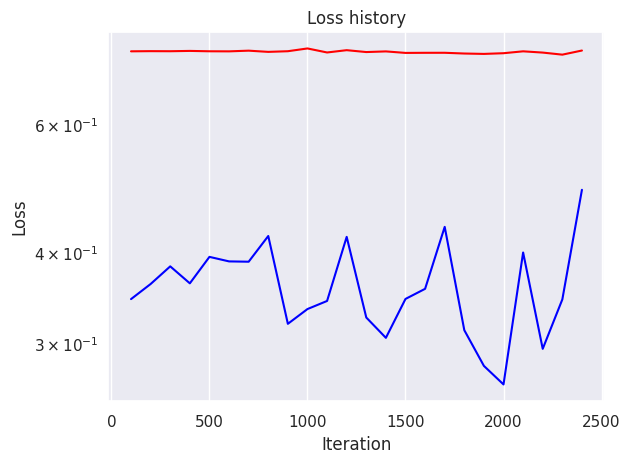

In [20]:
# loss history plot
sns.lineplot(x=counter, y=loss_history_train, color='blue')
sns.lineplot(x=counter, y=loss_history_val, color='red')
plt.yscale('log')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Now we need to use the network for prediction on our task. We take as result the answer which gives the highest output (closer to 1, the correct answer).

In [21]:
def tokenize_dataset(dataset, preprocess_function=preprocess_function):
    dataset_inputids = dataset.map(preprocess_function)['input_ids']
    dataset_inputids = [inputid for row in dataset_inputids for inputid in row]
    dataset_train_tokenized = {'input_ids': dataset_inputids}
    dataset_train_tokenized = Dataset.from_dict(dataset_train_tokenized).with_format('torch')
    return dataset_train_tokenized   

def predict(dataset, model):
    # tokenize the dataset
    dataset_tokenized = tokenize_dataset(dataset)

    # create the dataloader
    datacollator = DataCollatorWithPadding(tokenizer=fast_tokenizer)
    generator = torch.Generator(device=mydevice)
    dataloader = DataLoader(dataset_tokenized, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=datacollator, generator=generator)

    model.eval()

    # Apply the model to the data
    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(mydevice)
            outputs = model(input_ids)
            predictions = outputs.squeeze().cpu().numpy()
            all_predictions.extend(predictions)

    # Group the results by lists of 8 elements
    grouped_predictions = [all_predictions[i:i + 8] for i in range(0, len(all_predictions), 8)]

    # Predict the argmax for each list
    predicted_labels = [np.argmax(group) for group in grouped_predictions]

    # Convert the argmax to the corresponding letter
    predicted_labels = [chr(65+label) for label in predicted_labels]

    return predicted_labels


from sklearn.metrics import accuracy_score, f1_score
def evaluate_predictions(true_labels, predictions, dataset_label=None):
    # dataset_label is a string that specifies the dataset{'train', 'validation', 'test'}
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    print(f"{dataset_label} Accuracy:", accuracy)
    print(f"{dataset_label} F1 Score:", f1)
    return accuracy, f1
 

In [22]:
# now we use the original train and validation datasets
# load the model
BiLSTM_model = BiLSTM_Classifier(vocab_size, embedding_dim, padding_idx, out_features=out_features, lstm_layers=n_lstm_layers)
BiLSTM_model.load_state_dict(torch.load("models/BiLSTM_Classifier.model", weights_only=True, map_location=mydevice))

# predict
predicted_labels_train = predict(dataset_train, BiLSTM_model)
train_accuracy, train_f1 = evaluate_predictions(dataset_train['answerKey'], predicted_labels_train, 'train')

predicted_labels_val = predict(dataset_val, BiLSTM_model)
val_accuracy, val_f1 = evaluate_predictions(dataset_val['answerKey'], predicted_labels_val, 'validation')


Map:   0%|          | 0/7323 [00:00<?, ? examples/s]

train Accuracy: 0.1164823159907142
train F1 Score: 0.11647329303710716


Map:   0%|          | 0/811 [00:00<?, ? examples/s]

validation Accuracy: 0.12083847102342787
validation F1 Score: 0.12023731657314927


A simple LSTM is not enough, I think because this is trained from scratch and the classes don't carry a real meaning. The classes just tells if the answer is correct or not, a part from the final answer all the 8 sentences are identical. And also the model have seen just 8000 short sentences, which can be not enough for understanding language.

---
---
# **[SEP]**
---
---

---

# **x-transformer Encoder**

Now we can do exactly the same done with the LSTM, but with the Transformer Encoder only architecture

In [34]:
from x_transformers import TransformerWrapper, Encoder

# Hyperparameters
embedding_dim = 512
n_layers = 2
n_heads = 8

out_features = 128
learning_rate = 1e-4
batch_size = 128
nb_epoch = 6

# ---------------------

trf_model = TransformerWrapper(
    num_tokens = vocab_size,
    max_seq_len = fast_tokenizer.model_max_length,
    attn_layers = Encoder(
        dim = embedding_dim, # hidden dimensionality
        depth = n_layers, # number of layers
        heads = n_heads # number of self-attention heads
    )
)
trf_model.to(mydevice)

print(summary(trf_model))
# dimension of the output of the transformer
print('\nOuput shape')
print(trf_model(torch.randint(0, vocab_size, (1, fast_tokenizer.model_max_length)).to(mydevice)).shape)

Layer (type:depth-idx)                             Param #
TransformerWrapper                                 --
├─TokenEmbedding: 1-1                              --
│    └─Embedding: 2-1                              6,056,448
├─AbsolutePositionalEmbedding: 1-2                 --
│    └─Embedding: 2-2                              153,600
├─Identity: 1-3                                    --
├─Dropout: 1-4                                     --
├─Identity: 1-5                                    --
├─Encoder: 1-6                                     --
│    └─ModuleList: 2-3                             --
│    │    └─ModuleList: 3-1                        1,049,088
│    │    └─ModuleList: 3-2                        2,100,224
│    │    └─ModuleList: 3-3                        1,049,088
│    │    └─ModuleList: 3-4                        2,100,224
│    └─Identity: 2-4                               --
│    └─LayerNorm: 2-5                              512
│    │    └─LayerNorm: 3-5          

/home/max/.pyenv/versions/3.12.3/envs/nlp-env/lib/python3.12/site-packages/x_transformers/x_transformers.py:524: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/max/.pyenv/versions/3.12.3/envs/nlp-env/lib/python3.12/site-packages/x_transformers/x_transformers.py:548: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [35]:
trf_model

TransformerWrapper(
  (token_emb): TokenEmbedding(
    (emb): Embedding(11829, 512)
  )
  (pos_emb): AbsolutePositionalEmbedding(
    (emb): Embedding(300, 512)
  )
  (post_emb_norm): Identity()
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (project_emb): Identity()
  (attn_layers): Encoder(
    (layers): ModuleList(
      (0): ModuleList(
        (0): ModuleList(
          (0): LayerNorm(
            (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
          )
          (1-2): 2 x None
        )
        (1): Attention(
          (to_q): Linear(in_features=512, out_features=512, bias=False)
          (to_k): Linear(in_features=512, out_features=512, bias=False)
          (to_v): Linear(in_features=512, out_features=512, bias=False)
          (attend): Attend(
            (attn_dropout): Dropout(p=0.0, inplace=False)
          )
          (to_out): Linear(in_features=512, out_features=512, bias=False)
        )
        (2): Residual()
      )
      (1): ModuleList(
      

In [36]:

class TransformerClassifier(nn.Module):
    def __init__(self, trf_encoder, num_labels=2):
        super(TransformerClassifier, self).__init__()
        self.trf_encoder = trf_encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids):#, attention_mask):
        outputs = self.trf_encoder(input_ids=input_ids)#, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Use the output of the [CLS] token
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits